# **Netflix Content-Based Recommender (TF-IDF + Cosine)**

This notebook analyzes the Netflix Movies & TV Shows dataset to build a content-based recommender system using TF-IDF and cosine similarity.

**Dataset:**
* **Source:** https://www.kaggle.com/datasets/shivamb/netflix-shows
* **Format:** CSV
* **Size:** ~9000 rows

## 1. Setup and Import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import pandas as pd # Used for data manipulation and analysis
import numpy as np # Used for numerical operations
import matplotlib.pyplot as plt # Used for creating static visualizations
import seaborn as sns # Used for creating enhanced statistical visualizations
import plotly.express as px # Used for creating interactive visualizations
from sklearn.feature_extraction.text import TfidfVectorizer # Used for converting text to numerical features
from sklearn.metrics.pairwise import cosine_similarity # Used for measuring similarity between items
from sklearn.manifold import TSNE # For dimensionality reduction visualization
from collections import Counter # For counting items (like genres)
import re # For text cleaning using regular expressions

# Set display options and random seed for reproducibility
pd.set_option('display.max_colwidth', None)
np.random.seed(42)

# Set some visualization styles for consistency
sns.set(style = "whitegrid")

print("Google Drive mounted and all libraries imported successfully!")

Mounted at /content/drive
Google Drive mounted and all libraries imported successfully!


## 2. Load Data
### We load the dataset from the specified CSV file located in Google Drive into a pandas DataFrame.

In [3]:
file_path = '/content/drive/MyDrive/Netflixdata.csv'
# ------------------------------------

try:
    Netflixdata = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    # Display the first few rows and basic info
    print("First 5 rows of the dataset:")
    display(Netflixdata.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable with the correct path to your CSV file in Google Drive.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully.
First 5 rows of the dataset:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


## 3. Exploratory Data Analysis (EDA)
### We explore the data to understand its structure, quality, and uncover initial insights and trends.


## A) Data Quality Check

### Checking the shape, data types, and missing values

In [4]:
print("Dataset Shape:")
print(Netflixdata.shape)
print("\nDataset Info:")
Netflixdata.info()
print("\nDescriptive Statistics (for numerical columns):")
display(Netflixdata.describe())
print("\nMissing Values Summary:")
print(Netflixdata.isna().sum().sort_values(ascending= False))

Dataset Shape:
(8807, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Descriptive Statistics (for numerical columns):


,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000



Missing Values Summary:
director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64


Observations:


*   The dataset has 8807 rows and 12 columns
*   Significant missing values exist in director, country and cast.


*  Minor missing values in date_added,rating, and duration
*   release_year is the only numerical column initially.





## B) Univariate Analysis - Analyzing individual columns like type, rating, country, and release_year.

In [5]:
# Value counts for categorical features
print("\nProportion of Movies vs TV Shows:")
print(Netflixdata['type'].value_counts(normalize=True))
print("\nValue Counts for Rating:")
print(Netflixdata['rating'].value_counts())

# Top 10 Countries (Handling potential multiple countries per entry and NaNs)
print("\nTop 10 Production Countries:")
# Temporarily fill NaN for counting, then split, explode, strip, and count
countries_eda = (Netflixdata['country']
                 .fillna("Unknown") # Temporarily fillna for this specific analysis
                 .str.split(',')
                 .explode()
                 .str.strip())
top_10_countries = countries_eda.value_counts().head(10)
print(top_10_countries)


Proportion of Movies vs TV Shows:
type
Movie      0.696151
TV Show    0.303849
Name: proportion, dtype: float64

Value Counts for Rating:
rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

Top 10 Production Countries:
country
United States     3690
India             1046
Unknown            831
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Name: count, dtype: int64


## Visualizing Distributions:

###  Histogram: Netflix Titles Released per Year

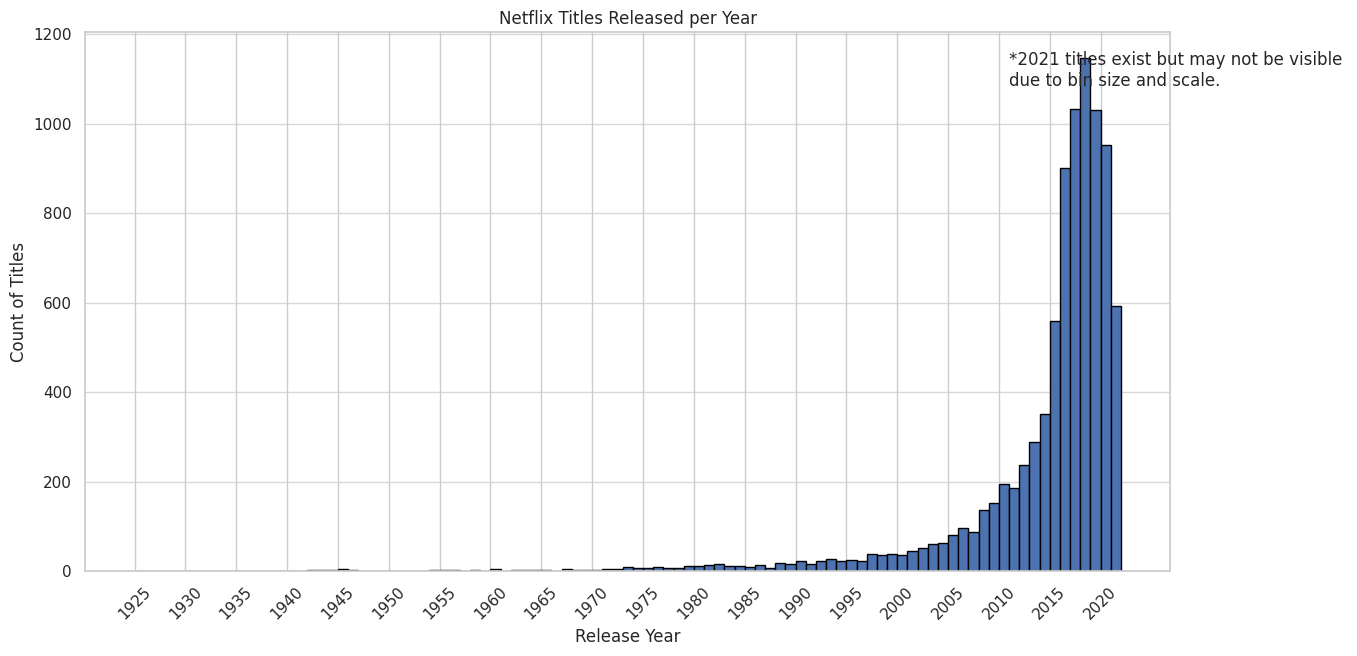

In [6]:
# Create bin edges for each year from min to max
min_year = Netflixdata['release_year'].min()
max_year = Netflixdata['release_year'].max()
bins = np.arange(min_year, max_year + 2, 1) # +2 to include the max year in the last bin

plt.figure(figsize=(14, 7))
plt.hist(Netflixdata['release_year'], bins=bins, edgecolor='black')
plt.title("Netflix Titles Released per Year")
plt.xlabel("Release Year")
plt.ylabel("Count of Titles")
plt.xticks(np.arange(min_year, max_year + 1, 5), rotation=45) # Show ticks every 5 years
# Add a note about 2021 potentially not showing due to bin width/scale if max_year is 2021
if max_year == 2021:
    plt.text(max_year - 10, plt.ylim()[1]*0.9, "*2021 titles exist but may not be visible \ndue to bin size and scale.", ha='left')
plt.grid(axis='y', alpha=0.75)
plt.show()

###  Bar Chart: Top 12 Genres

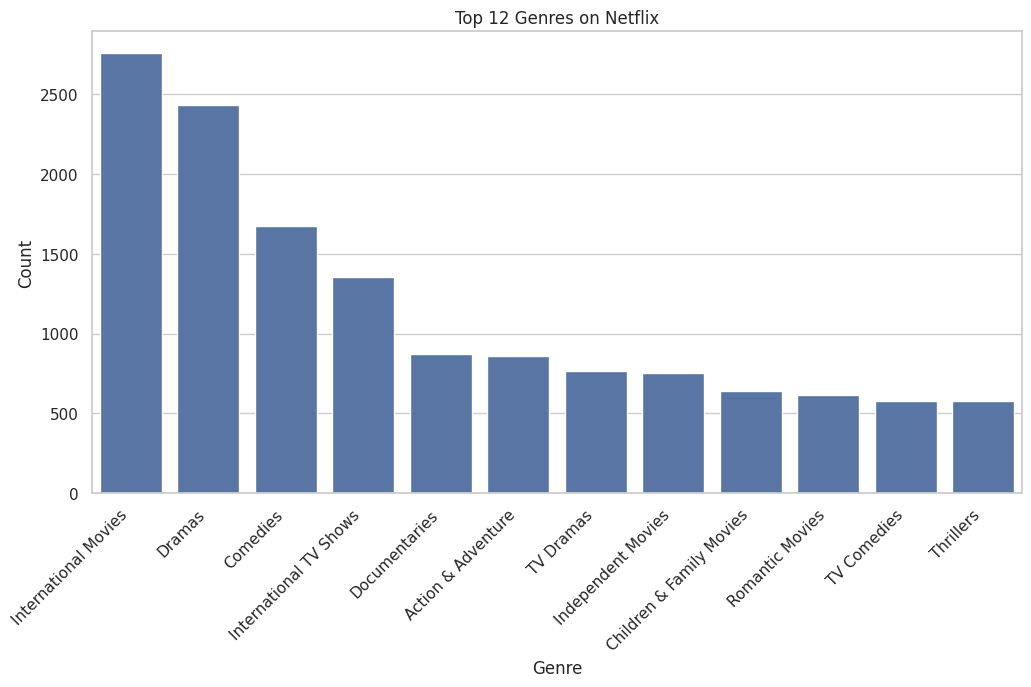

In [7]:
# Bar Chart: Top 12 Genres
genres_eda = (Netflixdata['listed_in']
              .str.split(',')
              .explode()
              .str.strip())
top_genres = Counter(genres_eda).most_common(12)
labels, values = zip(*top_genres)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(labels), y=list(values))
plt.title("Top 12 Genres on Netflix")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

### Bar Chart: Top 10 Countries

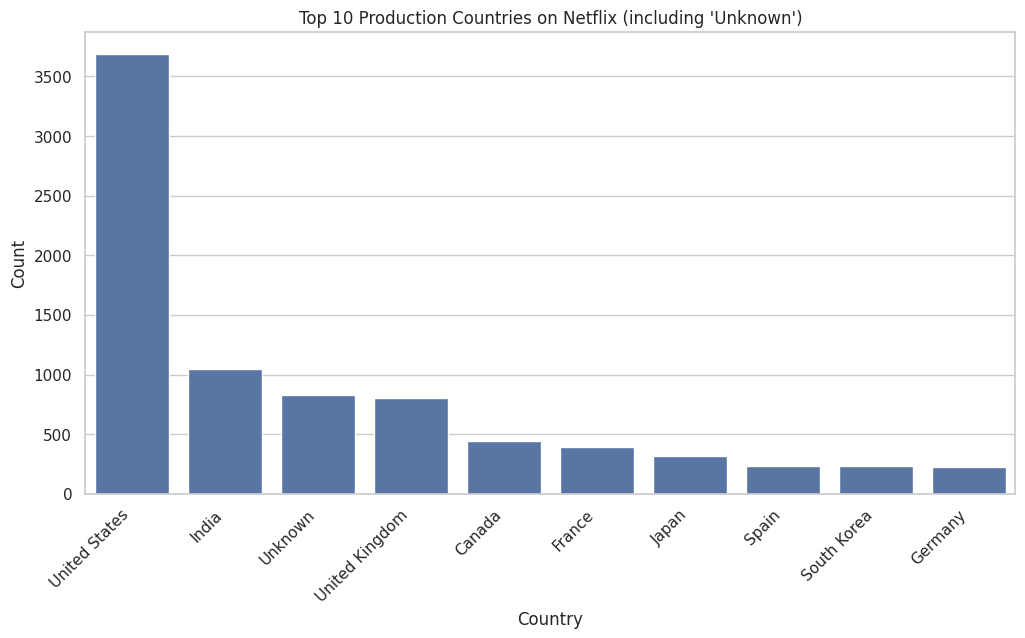

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries.values)
plt.title("Top 10 Production Countries on Netflix (including 'Unknown')")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

## C) Bivariate Analysis
### Analyzing the relationship between type (Movie/TV Show) and release_year.

### Line chart: Movies vs TV shows over Time

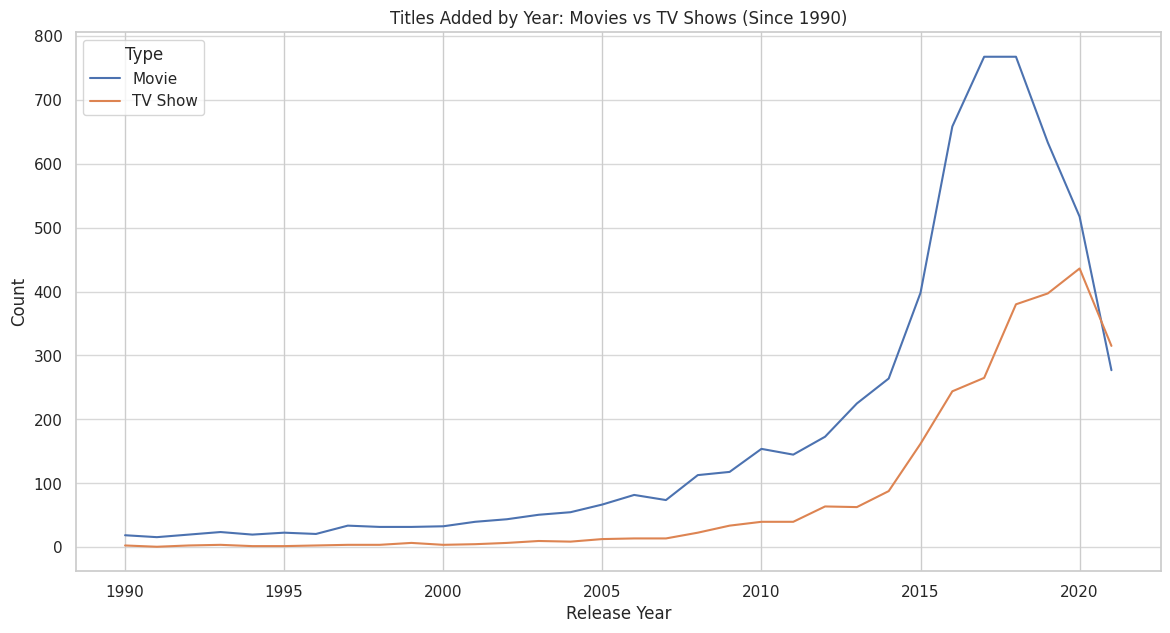

In [9]:
pivot = Netflixdata.pivot_table(index='release_year', columns='type', values='show_id', aggfunc='count').fillna(0)

# Filter out early years with very few titles for better visualization
pivot_filtered = pivot[pivot.index >= 1990]

plt.figure(figsize=(14, 7))
pivot_filtered.plot(kind='line', ax=plt.gca()) # Use ax=plt.gca() to plot on the created figure
plt.title("Titles Added by Year: Movies vs TV Shows (Since 1990)")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.legend(title='Type')
plt.grid(axis='y', alpha=0.75)
plt.show()

Summary:

Movies consistently outnumbered TV Shows added per year until roughly 2015; the rate of movie additions peaked much higher than TV shows around 2017-2018; afterward, the number of TV shows added per year became much closer to the number of movies added.This indicates a shift in production focus or acquisition.

## 4. Feature Engineering: Build Text Column

### We combine relevant text fields (title, listed_in, description) into a single 'text' column for the TF-IDF vectorizer. Text is lowercased for consistency. We also keep a display version of the title.

In [10]:
# Preserve original title for display later
Netflixdata['title_display'] = Netflixdata['title']

# Create a cleaned, lowercased version for text processing
Netflixdata['title_clean'] = Netflixdata['title'].str.lower().str.strip()

# Fill missing values in text columns with empty strings before concatenation
Netflixdata['listed_in'] = Netflixdata['listed_in'].fillna('')
Netflixdata['description'] = Netflixdata['description'].fillna('')

# Build the combined text column
Netflixdata['text'] = (
    Netflixdata['title_clean'] + ' ' +
    Netflixdata['listed_in'].str.lower() + ' ' +
    Netflixdata['description'].str.lower()
)

print("Created 'title_display', 'title_clean', and 'text' columns.")
print("\nExample 'text' column content for the first row:")
print(Netflixdata.loc[0, 'text'])

Created 'title_display', 'title_clean', and 'text' columns.

Example 'text' column content for the first row:
dick johnson is dead documentaries as her father nears the end of his life, filmmaker kirsten johnson stages his death in inventive and comical ways to help them both face the inevitable.


## 5. Modeling - Feature Extraction (TF-IDF)

### We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the combined text information for each title into a numerical vector representation.


*   TF (Term Frequency): Measures how often a word appears in a specific title's text.
*   IDF (Inverse Document Frequency): Reduces the weight of common words (like "the", "a") that appear in many titles and increases the weight of rarer, more descriptive words. This vectorization allows us to mathematically compare titles based on their content.



In [19]:
# Initialize and fit the TF-IDF Vectorizer
# We limit features to the top 5000 most frequent terms and remove common English stop words.
# Custom stopwords to hide generic streaming terms in explanations
custom_stop = ['english','tv','show','shows','series','season','episode','film','movie','movies']

tfidf = TfidfVectorizer(
    stop_words=custom_stop,    # <--- "tv" is included here
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000,
    sublinear_tf=True
)
X = tfidf.fit_transform(Netflixdata['text'])
feature_names = np.array(tfidf.get_feature_names_out())
print("TF-IDF matrix created.")
print("Shape of the TF-IDF matrix (rows=titles, columns=features):", X.shape)

TF-IDF matrix created.
Shape of the TF-IDF matrix (rows=titles, columns=features): (8807, 5000)


## 6. Recommender Function: Find Similar Titles

### We define a function that takes a title as input and returns the most similar titles based on Cosine Similarity. Cosine Similarity measures the cosine of the angle between two TF-IDF vectors. A smaller angle (cosine closer to 1) means the titles are more similar in content.

In [20]:
# Build a lookup dictionary: cleaned title -> row index for quick access
title_to_idx = {title: i for i, title in enumerate(Netflixdata['title_clean'])}

# --- Main Recommender Function ---
def recommend(user_title, k=10, type_filter=None):
    """
    Recommends titles similar to the user_title based on TF-IDF vectors and cosine similarity.

    Args:
        user_title (str): The title entered by the user (case-insensitive).
        k (int): The number of similar titles to return. Defaults to 10.
        type_filter (str, optional): Filter results by 'Movie' or 'TV Show'.
                                     If None, returns mixed types. Defaults to None.

    Returns:
        pandas.DataFrame or str: A DataFrame with recommended titles and their details,
                                 or an error message string if the title is not found.
    """
    # Normalize the user's input title
    key = str(user_title).lower().strip()

    # --- Input Validation ---
    if key not in title_to_idx:
        return f"Error: Title '{user_title}' not found in the dataset."

    # --- Find Input Title Index ---
    idx = title_to_idx[key]
    query_vector = X[idx]

    # --- Apply Type Filter (if specified) ---
    if type_filter in ("Movie", "TV Show"):
        # Get indices of titles matching the filter
        candidate_indices = np.where(Netflixdata['type'].values == type_filter)[0]
        if idx not in candidate_indices and len(candidate_indices) > 0:
             # Query title itself doesn't match the filter, calculate against candidates only
             pass # Or handle this edge case specifically
        elif len(candidate_indices) == 0:
             return f"No titles found matching the type filter '{type_filter}'."
        candidate_vectors = X[candidate_indices]
    else:
        # No filter, consider all titles
        candidate_indices = np.arange(len(Netflixdata))
        candidate_vectors = X

    # --- Calculate Similarities ---
    # Compute cosine similarity between the query vector and all candidate vectors
    sims = cosine_similarity(query_vector, candidate_vectors).ravel()

    # --- Rank and Select Top K ---
    # Get the indices of candidates sorted by similarity (highest first)
    sorted_candidate_indices_local = sims.argsort()[::-1]

    # Map back to original DataFrame indices
    ranked_original_indices = candidate_indices[sorted_candidate_indices_local]

    # Filter out the query title itself and take the top k
    top_indices = [j for j in ranked_original_indices if j != idx][:k]

    # --- Format and Return Results ---
    if not top_indices:
        return f"No similar {type_filter if type_filter else 'titles'} found for '{user_title}'."

    cols = ['title_display', 'type', 'listed_in', 'rating', 'release_year', 'description']
    recommendations = Netflixdata.iloc[top_indices][cols].reset_index(drop=True)
    return recommendations

In [21]:
# Example 1: Recommend any type similar to "Blood & Water"
print("Recommendations (Any Type) for 'Blood & Water':")
display(recommend("Blood & Water", k=5))

# Example 2: Recommend only MOVIES similar to "Blood & Water"
print("\nRecommendations (Movies Only) for 'Blood & Water':")
display(recommend("Blood & Water", k=5, type_filter="Movie"))

# Example 3: Recommend only TV SHOWS similar to "Blood & Water"
print("\nRecommendations (TV Shows Only) for 'Blood & Water':")
display(recommend("Blood & Water", k=5, type_filter="TV Show"))

# Example 4: Recommend any type similar to "Peaky Blinders"
print("\nRecommendations (Any Type) for 'Peaky Blinders':")
display(recommend("Peaky Blinders", k=5))

Recommendations (Any Type) for 'Blood & Water':


,title_display,type,listed_in,rating,release_year,description
0,Mom,Movie,"Dramas, International Movies, Thrillers",TV-14,2017,"After her stepdaughter is sexually assaulted at a party, a furious mother sets out to destroy the lives of the four perpetrators who walked away free."
1,20 Minutes,TV Show,"Crime TV Shows, International TV Shows, TV Dramas",TV-MA,2013,"When his wife is convicted of murder, a horrified family man races to prove her innocence while a dogged investigator sets out to uncover the truth."
2,Bigger Fatter Liar,Movie,"Children & Family Movies, Comedies",PG,2017,"When his video game concept is stolen by a dishonest executive, a teenage chronic liar sets out to prove that he's telling the truth, for once."
3,Toy Boy,TV Show,"Crime TV Shows, International TV Shows, Spanish-Language TV Shows",TV-MA,2019,"After seven years in a Málaga prison, a male stripper is released pending retrial and sets out to prove his lover framed him for her husband's murder."
4,A Perfect Man,Movie,"Dramas, Independent Movies, Romantic Movies",R,2013,"Nina thinks her husband, James, is cheating on her, and she sets out to prove it by calling him and pretending to be another woman."



Recommendations (Movies Only) for 'Blood & Water':


,title_display,type,listed_in,rating,release_year,description
0,Mom,Movie,"Dramas, International Movies, Thrillers",TV-14,2017,"After her stepdaughter is sexually assaulted at a party, a furious mother sets out to destroy the lives of the four perpetrators who walked away free."
1,Bigger Fatter Liar,Movie,"Children & Family Movies, Comedies",PG,2017,"When his video game concept is stolen by a dishonest executive, a teenage chronic liar sets out to prove that he's telling the truth, for once."
2,A Perfect Man,Movie,"Dramas, Independent Movies, Romantic Movies",R,2013,"Nina thinks her husband, James, is cheating on her, and she sets out to prove it by calling him and pretending to be another woman."
3,Not Another Teen Movie,Movie,Comedies,R,2001,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled artist into a prom queen in this outrageous parody."
4,Mrs. Serial Killer,Movie,"International Movies, Thrillers",TV-MA,2020,"When a doctor gets jailed for a string of shocking murders, his loyal wife sets out to commit a copycat crime to prove his innocence."



Recommendations (TV Shows Only) for 'Blood & Water':


,title_display,type,listed_in,rating,release_year,description
0,20 Minutes,TV Show,"Crime TV Shows, International TV Shows, TV Dramas",TV-MA,2013,"When his wife is convicted of murder, a horrified family man races to prove her innocence while a dogged investigator sets out to uncover the truth."
1,Toy Boy,TV Show,"Crime TV Shows, International TV Shows, Spanish-Language TV Shows",TV-MA,2019,"After seven years in a Málaga prison, a male stripper is released pending retrial and sets out to prove his lover framed him for her husband's murder."
2,46,TV Show,"International TV Shows, TV Dramas, TV Mysteries",TV-MA,2016,"A genetics professor experiments with a treatment for his comatose sister that blends medical and shamanic cures, but unlocks a shocking side effect."
3,More to Say,TV Show,"International TV Shows, TV Dramas, TV Mysteries",TV-14,2018,"After her son dies in an accident, a legal consultant is forced to prove her innocence when she's accused of his murder."
4,Legacies,TV Show,"TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows",TV-14,2019,"Born into a rare supernatural bloodline, Hope Mikaelson attends a gifted private school to master her powers and control her innate urges for evil."



Recommendations (Any Type) for 'Peaky Blinders':


,title_display,type,listed_in,rating,release_year,description
0,Inside the World’s Toughest Prisons,TV Show,"British TV Shows, Crime TV Shows, Docuseries",TV-MA,2021,"Investigative journalist Paul Connolly becomes a voluntary inmate in the world's most volatile prisons, where intimidation and brutality rule."
1,The Fear,TV Show,"British TV Shows, Crime TV Shows, TV Dramas",TV-MA,2012,"Richie Beckett is an aging Brighton crime boss who's struggling with the onset of dementia, just as a rival gang is trying to take over his territory."
2,The Office (U.S.),TV Show,TV Comedies,TV-14,2012,This hit comedy chronicles the foibles of disgruntled office workers – led by deluded boss Michael Scott – at the Dunder Mifflin paper company.
3,Criminal: Spain,TV Show,"British TV Shows, Crime TV Shows, International TV Shows",TV-MA,2019,"Psychological games abound between detectives and suspects in a tense interrogation room, where the search for answers sometimes comes at a moral cost."
4,Abnormal Summit,TV Show,"International TV Shows, Korean TV Shows, Stand-Up Comedy & Talk Shows",TV-PG,2017,"Led by a trio of Korean celebs, a multinational panel of men engage in – usually – lighthearted debates on issues that surround Korea and beyond."


## 7. Mixed Recommender Function
### Define a function to return a mix of Movies and TV Shows.

In [22]:
def recommend_mixed(user_title, total=10):
    """
    Recommends a mix of Movies and TV Shows similar to the user_title.

    Args:
        user_title (str): The title entered by the user (case-insensitive).
        total (int): The total number of recommendations to return. Defaults to 10.

    Returns:
        pandas.DataFrame or str: A DataFrame with recommended titles,
                                 or an error message string if the title is not found.
    """
    # Check if the title exists first to avoid errors in the main recommend function
    key = str(user_title).lower().strip()
    if key not in title_to_idx:
        return f"Error: Title '{user_title}' not found in the dataset."

    half = total // 2
    num_tv_shows = total - half

    # Get recommendations for each type
    recs_movies = recommend(user_title, k=half, type_filter="Movie")
    recs_tv_shows = recommend(user_title, k=num_tv_shows, type_filter="TV Show")

    # Handle cases where one type might not return results (returns a string)
    results = []
    if isinstance(recs_movies, pd.DataFrame):
        results.append(recs_movies)
    if isinstance(recs_tv_shows, pd.DataFrame):
        results.append(recs_tv_shows)

    if not results:
        return f"No similar Movies or TV Shows found for '{user_title}'."

    # Combine the results
    return pd.concat(results, ignore_index=True)

In [23]:
print("\nRecommendations (Mixed - 5 Movies, 5 TV Shows) for 'Blood & Water':")
display(recommend_mixed("Blood & Water", total=10))


Recommendations (Mixed - 5 Movies, 5 TV Shows) for 'Blood & Water':


,title_display,type,listed_in,rating,release_year,description
0,Mom,Movie,"Dramas, International Movies, Thrillers",TV-14,2017,"After her stepdaughter is sexually assaulted at a party, a furious mother sets out to destroy the lives of the four perpetrators who walked away free."
1,Bigger Fatter Liar,Movie,"Children & Family Movies, Comedies",PG,2017,"When his video game concept is stolen by a dishonest executive, a teenage chronic liar sets out to prove that he's telling the truth, for once."
2,A Perfect Man,Movie,"Dramas, Independent Movies, Romantic Movies",R,2013,"Nina thinks her husband, James, is cheating on her, and she sets out to prove it by calling him and pretending to be another woman."
3,Not Another Teen Movie,Movie,Comedies,R,2001,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled artist into a prom queen in this outrageous parody."
4,Mrs. Serial Killer,Movie,"International Movies, Thrillers",TV-MA,2020,"When a doctor gets jailed for a string of shocking murders, his loyal wife sets out to commit a copycat crime to prove his innocence."
5,20 Minutes,TV Show,"Crime TV Shows, International TV Shows, TV Dramas",TV-MA,2013,"When his wife is convicted of murder, a horrified family man races to prove her innocence while a dogged investigator sets out to uncover the truth."
6,Toy Boy,TV Show,"Crime TV Shows, International TV Shows, Spanish-Language TV Shows",TV-MA,2019,"After seven years in a Málaga prison, a male stripper is released pending retrial and sets out to prove his lover framed him for her husband's murder."
7,46,TV Show,"International TV Shows, TV Dramas, TV Mysteries",TV-MA,2016,"A genetics professor experiments with a treatment for his comatose sister that blends medical and shamanic cures, but unlocks a shocking side effect."
8,More to Say,TV Show,"International TV Shows, TV Dramas, TV Mysteries",TV-14,2018,"After her son dies in an accident, a legal consultant is forced to prove her innocence when she's accused of his murder."
9,Legacies,TV Show,"TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows",TV-14,2019,"Born into a rare supernatural bloodline, Hope Mikaelson attends a gifted private school to master her powers and control her innate urges for evil."


## 8. Explainability: Show Top Keywords

### To understand why certain titles are recommended, we can extract the most important TF-IDF terms (keywords) for the query title and its recommendations.

In [24]:
# Define functions to get top terms

def _top_terms_for_row(row_vec, n=12):
    """Helper function to get top N terms from a TF-IDF row vector."""
    arr = row_vec.toarray().ravel()
    # Get indices of the top N terms by TF-IDF score
    idx = arr.argsort()[::-1][:n]
    # Return the corresponding feature names (terms)
    return feature_names[idx].tolist()

def keywords_for_query_and_recs(user_title, k=5, n_terms=12):
    """
    Gets the top TF-IDF keywords for the query title and its top k recommendations.

    Args:
        user_title (str): The title entered by the user (case-insensitive).
        k (int): The number of similar titles to analyze. Defaults to 5.
        n_terms (int): The number of top keywords to show for each title. Defaults to 12.

    Returns:
        pandas.DataFrame or str: A DataFrame showing titles, types, and their top keywords,
                                 or an error message if the title is not found.
    """
    key = str(user_title).lower().strip()
    if key not in title_to_idx:
        return f"Title '{user_title}' not found."

    i = title_to_idx[key]
    query_vector = X[i]

    # Find recommendations (considering all types for keyword analysis)
    sims = cosine_similarity(query_vector, X).ravel()
    order = sims.argsort()[::-1]
    recs_indices = [j for j in order if j != i][:k] # Get original indices of recs

    # Prepare data for DataFrame
    rows = []
    # Add query title info
    rows.append({
        "title": f"[Query] {Netflixdata.iloc[i]['title_display']}",
        "type":  Netflixdata.iloc[i]['type'],
        "keywords": ", ".join(_top_terms_for_row(query_vector, n_terms))
    })
    # Add recommendation info
    for j in recs_indices:
        rec_vector = X[j]
        rows.append({
            "title": Netflixdata.iloc[j]['title_display'],
            "type":  Netflixdata.iloc[j]['type'],
            "keywords": ", ".join(_top_terms_for_row(rec_vector, n_terms))
        })
    return pd.DataFrame(rows)

### Example: Keywords for "Blood & Water" and its Recommendations

In [25]:
print("\nTop Keywords explaining similarity for 'Blood & Water':")
display(keywords_for_query_and_recs("Blood & Water", k=5, n_terms=10))


Top Keywords explaining similarity for 'Blood & Water':


,title,type,keywords
0,[Query] Blood & Water,TV Show,"private school, abducted, who was, whether, her sister, water, birth, private, blood, to prove"
1,Mom,Movie,"sexually, to destroy, destroy, after her, thrillers after, the lives, lives of, mom, free, party"
2,20 Minutes,TV Show,"races, family man, innocence, investigator, of murder, convicted, uncover the, to uncover, 20, uncover"
3,Bigger Fatter Liar,Movie,"telling, video game, executive, stolen, that he, to prove, video, prove, the truth, once"
4,Toy Boy,TV Show,"prove his, him for, toy, released, years in, framed, male, lover, to prove, seven"
5,A Perfect Man,Movie,"man dramas, her and, and she, calling, cheating, thinks, him and, james, independent romantic, to prove"


## 9. Advanced Visualization - Dimensionality Reduction (t-SNE)

### We use t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the high-dimensional TF-IDF vectors (5000 dimensions) down to 2 dimensions. This allows us to create a 2D scatter plot visualizing the content relationships in the Netflix catalog. Titles with similar content should appear closer together on the map.


Running t-SNE on 2000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed.


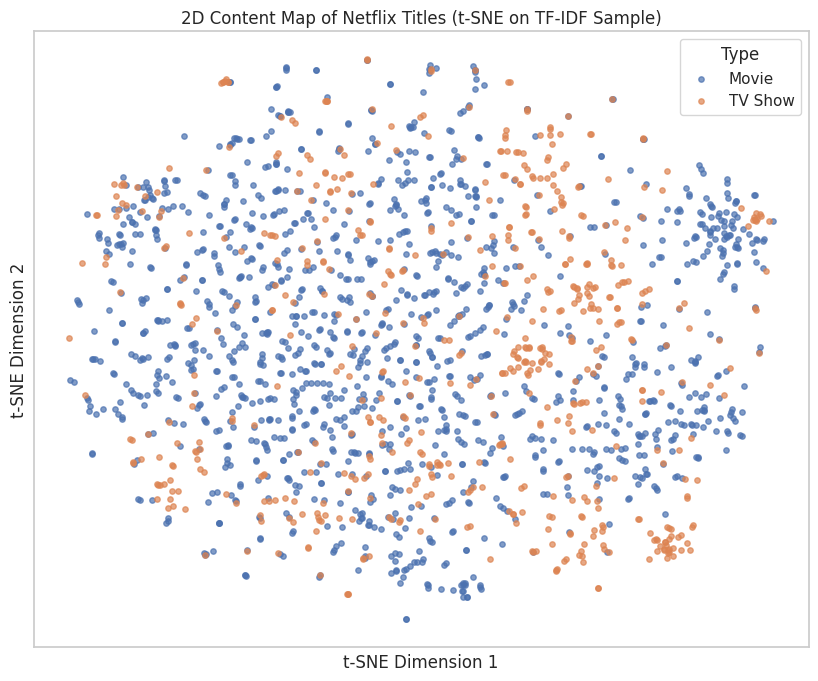

In [26]:
# --- t-SNE Visualization ---
# We use a random sample for speed, as t-SNE can be computationally intensive.
num_samples = 2000
idx_sample = np.random.RandomState(42).choice(X.shape[0], size=min(num_samples, X.shape[0]), replace=False)

X_small = X[idx_sample]
types_small = Netflixdata.iloc[idx_sample]['type'].values # Get types for coloring

print(f"\nRunning t-SNE on {X_small.shape[0]} samples...")

# Initialize and fit t-SNE
# Adjust perplexity based on sample size if needed (typical range 5-50)
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42, n_iter=300)
XY = tsne.fit_transform(X_small.toarray()) # Convert sparse matrix to dense for t-SNE

print("t-SNE completed.")

# Create the scatter plot
plt.figure(figsize=(10, 8))
for t in ['Movie', 'TV Show']:
    mask = (types_small == t)
    plt.scatter(XY[mask, 0], XY[mask, 1], s=15, label=t, alpha=0.7)

plt.title("2D Content Map of Netflix Titles (t-SNE on TF-IDF Sample)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Type')
plt.xticks([]) # Hide axis ticks for clarity
plt.yticks([])
plt.show()

**Figure: 2D Content Map (t-SNE Visualization)**

This plot visualizes the content similarity between a sample of Netflix titles using t-SNE to reduce the dimensionality of the TF-IDF vectors. Each point represents a title, colored by its type (Movie or TV Show). Titles with similar content descriptions appear closer together.

**Key Interpretations:**
* There is **significant overlap** between Movies (blue) and TV Shows (orange), suggesting many shared themes and descriptive words across formats.
* Despite the overlap, there's a **tendency for some separation**, indicating that content features captured by TF-IDF still allow for partial distinction between movies and TV shows overall.

## 10. Conclusion

This project successfully built a content-based recommender system for Netflix titles using TF-IDF and cosine similarity. We performed EDA to understand the data, engineered features by combining text fields, and created functions to provide recommendations with optional type filtering and keyword-based explanations. The t-SNE visualization provides a high-level map of content similarity across the catalog.